# Stock Predictor based on RNN Architecture tuned with LSTMs

### Using the Google Stock Price between 2012 - 2017 for the model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.models import load_model

Using TensorFlow backend.


In [2]:
path = './Google_Stock_Price_Train.csv'

In [3]:
train_dataset = pd.read_csv(path)

In [4]:
train_dataset.describe()

,Open,High,Low
count,1258.000000,1258.000000,1258.000000
mean,533.709833,537.880223,529.007409
std,151.904442,153.008811,150.552807
min,279.120000,281.210000,277.220000
25%,404.115000,406.765000,401.765000
50%,537.470000,540.750000,532.990000
75%,654.922500,662.587500,644.800000
max,816.680000,816.680000,805.140000


In [5]:
train_dataset.dtypes

Date       object
Open      float64
High      float64
Low       float64
Close      object
Volume     object
dtype: object

Converting close into float

In [6]:
d = train_dataset.Close[451]

In [7]:
d

'1,008.64'

In [8]:
close = [d.split(",")[0]+d.split(",")[1] if d.count(',') >= 1 else d for d in train_dataset.Close ]

In [9]:
train_dataset.Close = close

In [10]:
train_dataset.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [11]:
train_dataset.Close = pd.to_numeric(train_dataset.Close)

In [12]:
train_dataset.dtypes

Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume     object
dtype: object

In [13]:
train_dataset.Date = pd.to_datetime(train_dataset.Date)

In [14]:
train_dataset.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume            object
dtype: object

In [15]:
sea.set_style('darkgrid')
plt.rcParams['figure.figsize'] = 16,7

### Stock price trend

/home/pratik/.local/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Close Price Trend')

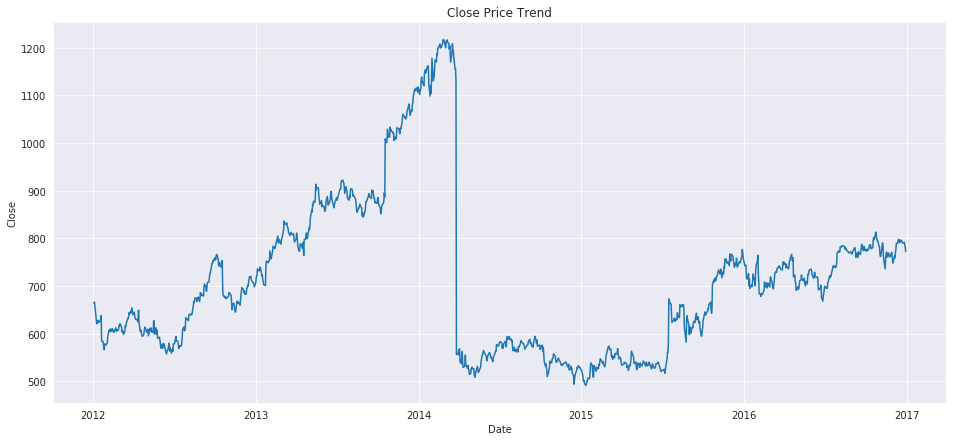

In [16]:
sea.lineplot(data = train_dataset, x = train_dataset.Date, y = train_dataset.Close)
plt.title('Close Price Trend')

##### You can find more info about why there was a sharp decline in prices in the early quarter of 2014 here:  
https://money.cnn.com/2014/12/18/investing/google-stock/index.html

### SMA Returns

In [17]:
train_dataset['Day_per_change'] = train_dataset.Close.pct_change()*100

In [18]:
train_dataset[:10]

,Date,Open,High,Low,Close,Volume,Day_per_change
0,2012-01-03,325.25,332.83,324.97,663.59,"7,380,500",NaN
1,2012-01-04,331.27,333.87,329.08,666.45,"5,749,400",0.430989
2,2012-01-05,329.83,330.75,326.89,657.21,"6,590,300",-1.386451
3,2012-01-06,328.34,328.77,323.68,648.24,"5,405,900",-1.364861
4,2012-01-09,322.04,322.29,309.46,620.76,"11,688,800",-4.239171
5,2012-01-10,313.70,315.72,307.30,621.43,"8,824,000",0.107932
6,2012-01-11,310.59,313.52,309.40,624.25,"4,817,800",0.453792
7,2012-01-12,314.43,315.26,312.08,627.92,"3,764,400",0.587905
8,2012-01-13,311.96,312.30,309.37,623.28,"4,631,800",-0.738948
9,2012-01-17,314.81,314.81,311.67,626.86,"3,832,800",0.574381


In [19]:
SMA = train_dataset.Day_per_change.rolling(7).mean()

[Text(0, 0.5, '% Returns'),
 Text(0.5, 0, 'Dates'),
 Text(0.5, 1.0, 'SMA Returns weekly between 2012 - 2013')]

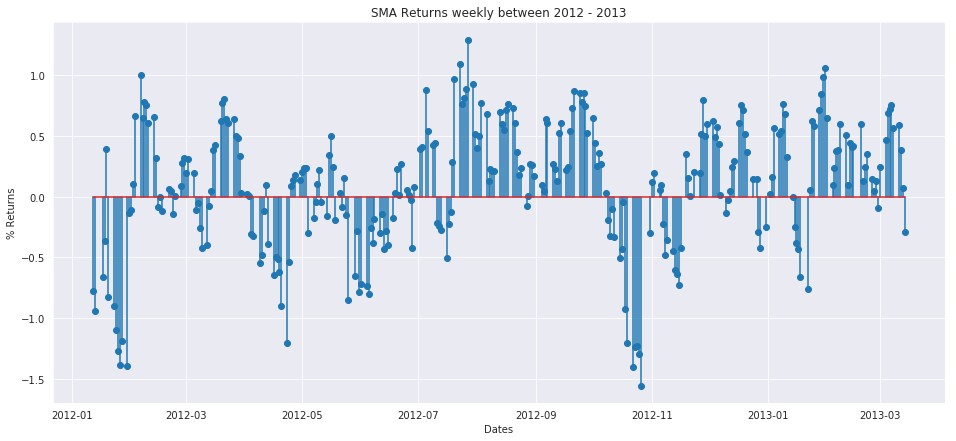

In [20]:
plt.stem(train_dataset.Date[7:300], SMA[7:300])
plt.gca().set(xlabel = 'Dates', ylabel = '% Returns', title = 'SMA Returns weekly between 2012 - 2013')

In [21]:
train_dataset['SMA_20'] = train_dataset.Close.rolling(20).mean() 

In [22]:
train_dataset['SMA_50'] = train_dataset.Close.rolling(50).mean()

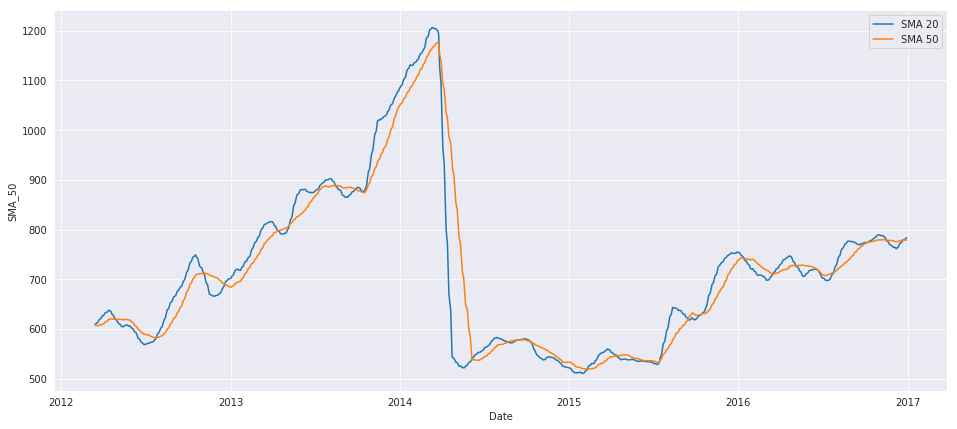

In [23]:
sea.lineplot(x = train_dataset.Date[49:],y = train_dataset.SMA_20[49:], label = 'SMA 20' )
sea.lineplot(x = train_dataset.Date[49:],y = train_dataset.SMA_50[49:], label = 'SMA 50' )

When the 20 day Simple Moving Average becomes lesser than the 50-day counterpart, its a clear sign of a downward trend and to initiate a short position.

Conversely,When the 20 day Simple Moving Average becomes greater than the 50-day counterpart, its a clear sign of a upward trend and to initiate a long position.

### Bollinger Analysis

In [24]:
train_dataset['mid_band'] = train_dataset.Close.rolling(14).mean()

In [25]:
train_dataset['upper_band'] = train_dataset.mid_band + 2*train_dataset.Close.rolling(14).std()
train_dataset['lower_band'] = train_dataset.mid_band - 2*train_dataset.Close.rolling(14).std()

[Text(0, 0.5, 'Stock price Movement'),
 Text(0.5, 0, 'Dates'),
 Text(0.5, 1.0, 'Bollinger Analysis')]

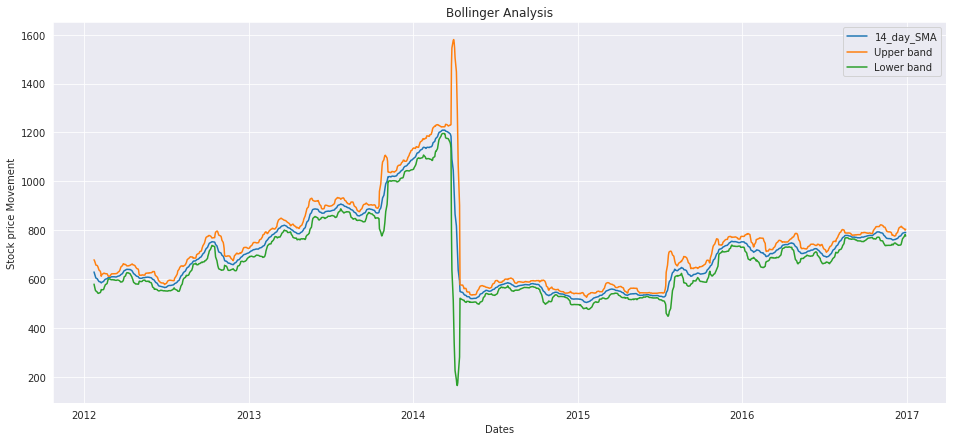

In [26]:
sea.lineplot(x=train_dataset.Date[13:], y =train_dataset.mid_band[13:], label = '14_day_SMA')
sea.lineplot(x=train_dataset.Date[13:], y =train_dataset.upper_band[13:], label = 'Upper band')
sea.lineplot(x=train_dataset.Date[13:], y =train_dataset.lower_band[13:], label = 'Lower band')
plt.gca().set(xlabel = 'Dates', ylabel = 'Stock price Movement', title = 'Bollinger Analysis')

Inference : Apart from the high volatility due to the downtrend of 2014, the volatility of the stock tends to be quite low, thus, a safer option for any stock portfolio. Also, there are very few sideway movements and generally the bands are well squished 

### Preprocessing the data to be compatible with stacked arhitecture

Choosing the open price as a vector input

In [27]:
train_set = train_dataset.iloc[:,1:2].values

As, normalization works better while capturing stock movements, thus using it.

In [28]:
sc = MinMaxScaler(feature_range=(0, 1))
scaled_train_set = sc.fit_transform(train_set)

Creating a data-structure with 60 timesteps and 1 output. In general, this means the model will look back upon the last 60 observations and likewise operate the FMO valves in LSTMs.

In [29]:
x_train = []
y_train = []

In [30]:
for i in range(100, 1258):
    x_train.append(scaled_train_set[i-100 : i, 0])
    y_train.append(scaled_train_set[i, 0])

In [31]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [32]:
# Reshape for keras
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

### RNN Model

In [35]:
RNNregressor = Sequential()

First LSTM layer

In [36]:
RNNregressor.add(LSTM(units=60, return_sequences=True, input_shape = ( x_train.shape[1], 1)))
RNNregressor.add(Dropout(rate=0.2))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Second LSTM layer

In [37]:
RNNregressor.add(LSTM(units=100, return_sequences=True))
RNNregressor.add(Dropout(rate=0.2))

Third LSTM layer

In [38]:
RNNregressor.add(LSTM(units=100, return_sequences=True))
RNNregressor.add(Dropout(rate=0.2))

Fourth LSTM layer


In [39]:
RNNregressor.add(LSTM(units=100, return_sequences=True))
RNNregressor.add(Dropout(rate=0.2))

Fifth LSTM layer

In [40]:
RNNregressor.add(LSTM(units=100))
RNNregressor.add(Dropout(rate=0.2))

Wrec doesn't need to move any further, thus, return sequences set to False

In [41]:
RNNregressor.add(Dense(units=1))
RNNregressor.compile(optimizer='adam', loss='mean_squared_error')

RMSprop also a good alternative

In [42]:
RNNregressor.fit(x_train, y_train, epochs= 100, batch_size= 32 )

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1158/1158 [==============================] - 57s 49ms/step - loss: 0.0453
Epoch 2/100
1158/1158 [==============================] - 43s 37ms/step - loss: 0.0044
Epoch 3/100
1158/1158 [==============================] - 43s 37ms/step - loss: 0.0041
Epoch 4/100
1158/1158 [==============================] - 48s 42ms/step - loss: 0.0044
Epoch 5/100
1158/1158 [==============================] - 47s 41ms/step - loss: 0.0045
Epoch 6/100
1158/1158 [==============================] - 44s 38ms/step - loss: 0.0044
Epoch 7/100
1158/1158 [==============================] - 44s 38ms/step - loss: 0.0035
Epoch 8/100
1158/1158 [==============================] - 48s 41ms/step - loss: 0.0036
Epoch 9/100
1158/1158 [==============================] - 54s 47ms/step - loss: 0.0039
Epoch 10/100
1158/1158 [==============================] - 47s 40ms/step - loss: 0.0045
Epoch 11/100
1158/1158 [==============================] - 47s 41ms/step - loss: 0.0035
Epoc

1158/1158 [==============================] - 43s 37ms/step - loss: 0.0013
Epoch 93/100
1158/1158 [==============================] - 43s 37ms/step - loss: 0.0013
Epoch 94/100
1158/1158 [==============================] - 43s 37ms/step - loss: 0.0014
Epoch 95/100
1158/1158 [==============================] - 43s 37ms/step - loss: 0.0014
Epoch 96/100
1158/1158 [==============================] - 43s 37ms/step - loss: 0.0012
Epoch 97/100
1158/1158 [==============================] - 42s 37ms/step - loss: 0.0013
Epoch 98/100
1158/1158 [==============================] - 43s 37ms/step - loss: 0.0014
Epoch 99/100
1158/1158 [==============================] - 43s 37ms/step - loss: 0.0016
Epoch 100/100
1158/1158 [==============================] - 43s 37ms/step - loss: 0.0012


In [55]:
RNNregressor.save('stock_5_rnn.h5')

#### Loading the previous model

In [33]:
stock_rnn = load_model('stock_rnn.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [42]:
stock_rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 60)           14880     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 60)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 60)           29040     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 60)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 60)           29040     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 60)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 60)                29040     
__________

#### Loading the tuned model

In [40]:
stock_tuned = load_model('stock_5_rnn.h5')

In [41]:
stock_tuned.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 60)           14880     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 60)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 100)          64400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 100)          80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 100)          80400     
__________

### Predicting Stock Prices of January 2017

In [43]:
test_dataset = pd.read_csv('./Google_Stock_Price_Test.csv')
real_stock_price = test_dataset.iloc[:, 1:2].values

In [44]:
dataset_total = pd.concat((train_dataset.Open, test_dataset.Open), axis = 0)
inputs = dataset_total[len(dataset_total)-len(test_dataset) - 100 :].values

In [45]:
inputs = inputs.reshape(-1,1)

In [46]:
inputs = sc.transform(inputs)

In [47]:
x_test = []
for i in range(100, 120):
    x_test.append(inputs[i-100 : i, 0])
    
x_test = np.array(x_test)

In [48]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))    

#### With the initial model

In [50]:
predicted_stock_price = stock_rnn.predict(x_test)

In [51]:
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

#### With the tuned model

In [52]:
predicted_stock_price_tuned = stock_tuned.predict(x_test)

In [53]:
predicted_stock_price_tuned = sc.inverse_transform(predicted_stock_price_tuned)

In [54]:
test_dataset.Date = pd.to_datetime(test_dataset.Date)

In [64]:
real_stock_price = real_stock_price.flatten()

In [72]:
predicted_stock_price = predicted_stock_price.flatten()

In [74]:
predicted_stock_price_tuned = predicted_stock_price_tuned.flatten()

#### Comparison of the predictions made by the models

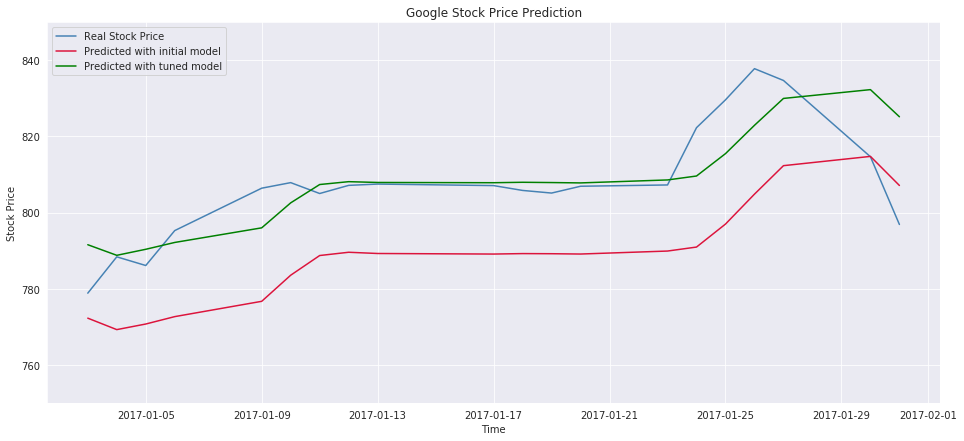

In [83]:
plt.ylim(750,850)
sea.lineplot(y=real_stock_price, x=test_dataset.Date, color = 'steelblue', label = 'Real Stock Price')
sea.lineplot(y=predicted_stock_price, x=test_dataset.Date, color = 'Crimson', label = 'Predicted with initial model')
sea.lineplot(y=predicted_stock_price_tuned, x=test_dataset.Date, color = 'Green', label = 'Predicted with tuned model')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


#### Inference:
It is evident that both the models were able to predict the trend of the stock price movement quite nicely. However, it is clearly seen that the tuned model with 5 LSTM layers with 100 units performed much better when it comes to predicting the actual stock price while showing the trend as well.